# Start work

In [1]:
import pandas as pd
import zipfile
from datetime import datetime
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve2d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import lightgbm as lgb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
#load zip file
zf = zipfile.ZipFile('data.zip')

In [3]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [4]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


You can draw the wafers map to see how the wafers look like in the data.

Using the following helper function you can draw the wafer maps with or without labels:

In [5]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')

    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2))

        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)

        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    import numpy as np
    import matplotlib.pyplot as plt

    if labels:
        if len(wafer_df_list) > 1:
            fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize * len(wafer_df_list), figsize * 2))
            for idx1, wafer_df in enumerate(wafer_df_list):
                for idx2, map_type in enumerate(['Input', 'Label']):
                    plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
        else:  #had to change it a little so it will handle one wafer input
            fig, ax = plt.subplots(2, 1, figsize=(figsize, figsize * 2))
            plot_wafer_map(wafer_df_list[0], ax[0], 'Input')
            plot_wafer_map(wafer_df_list[0], ax[1], 'Label')
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize * len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

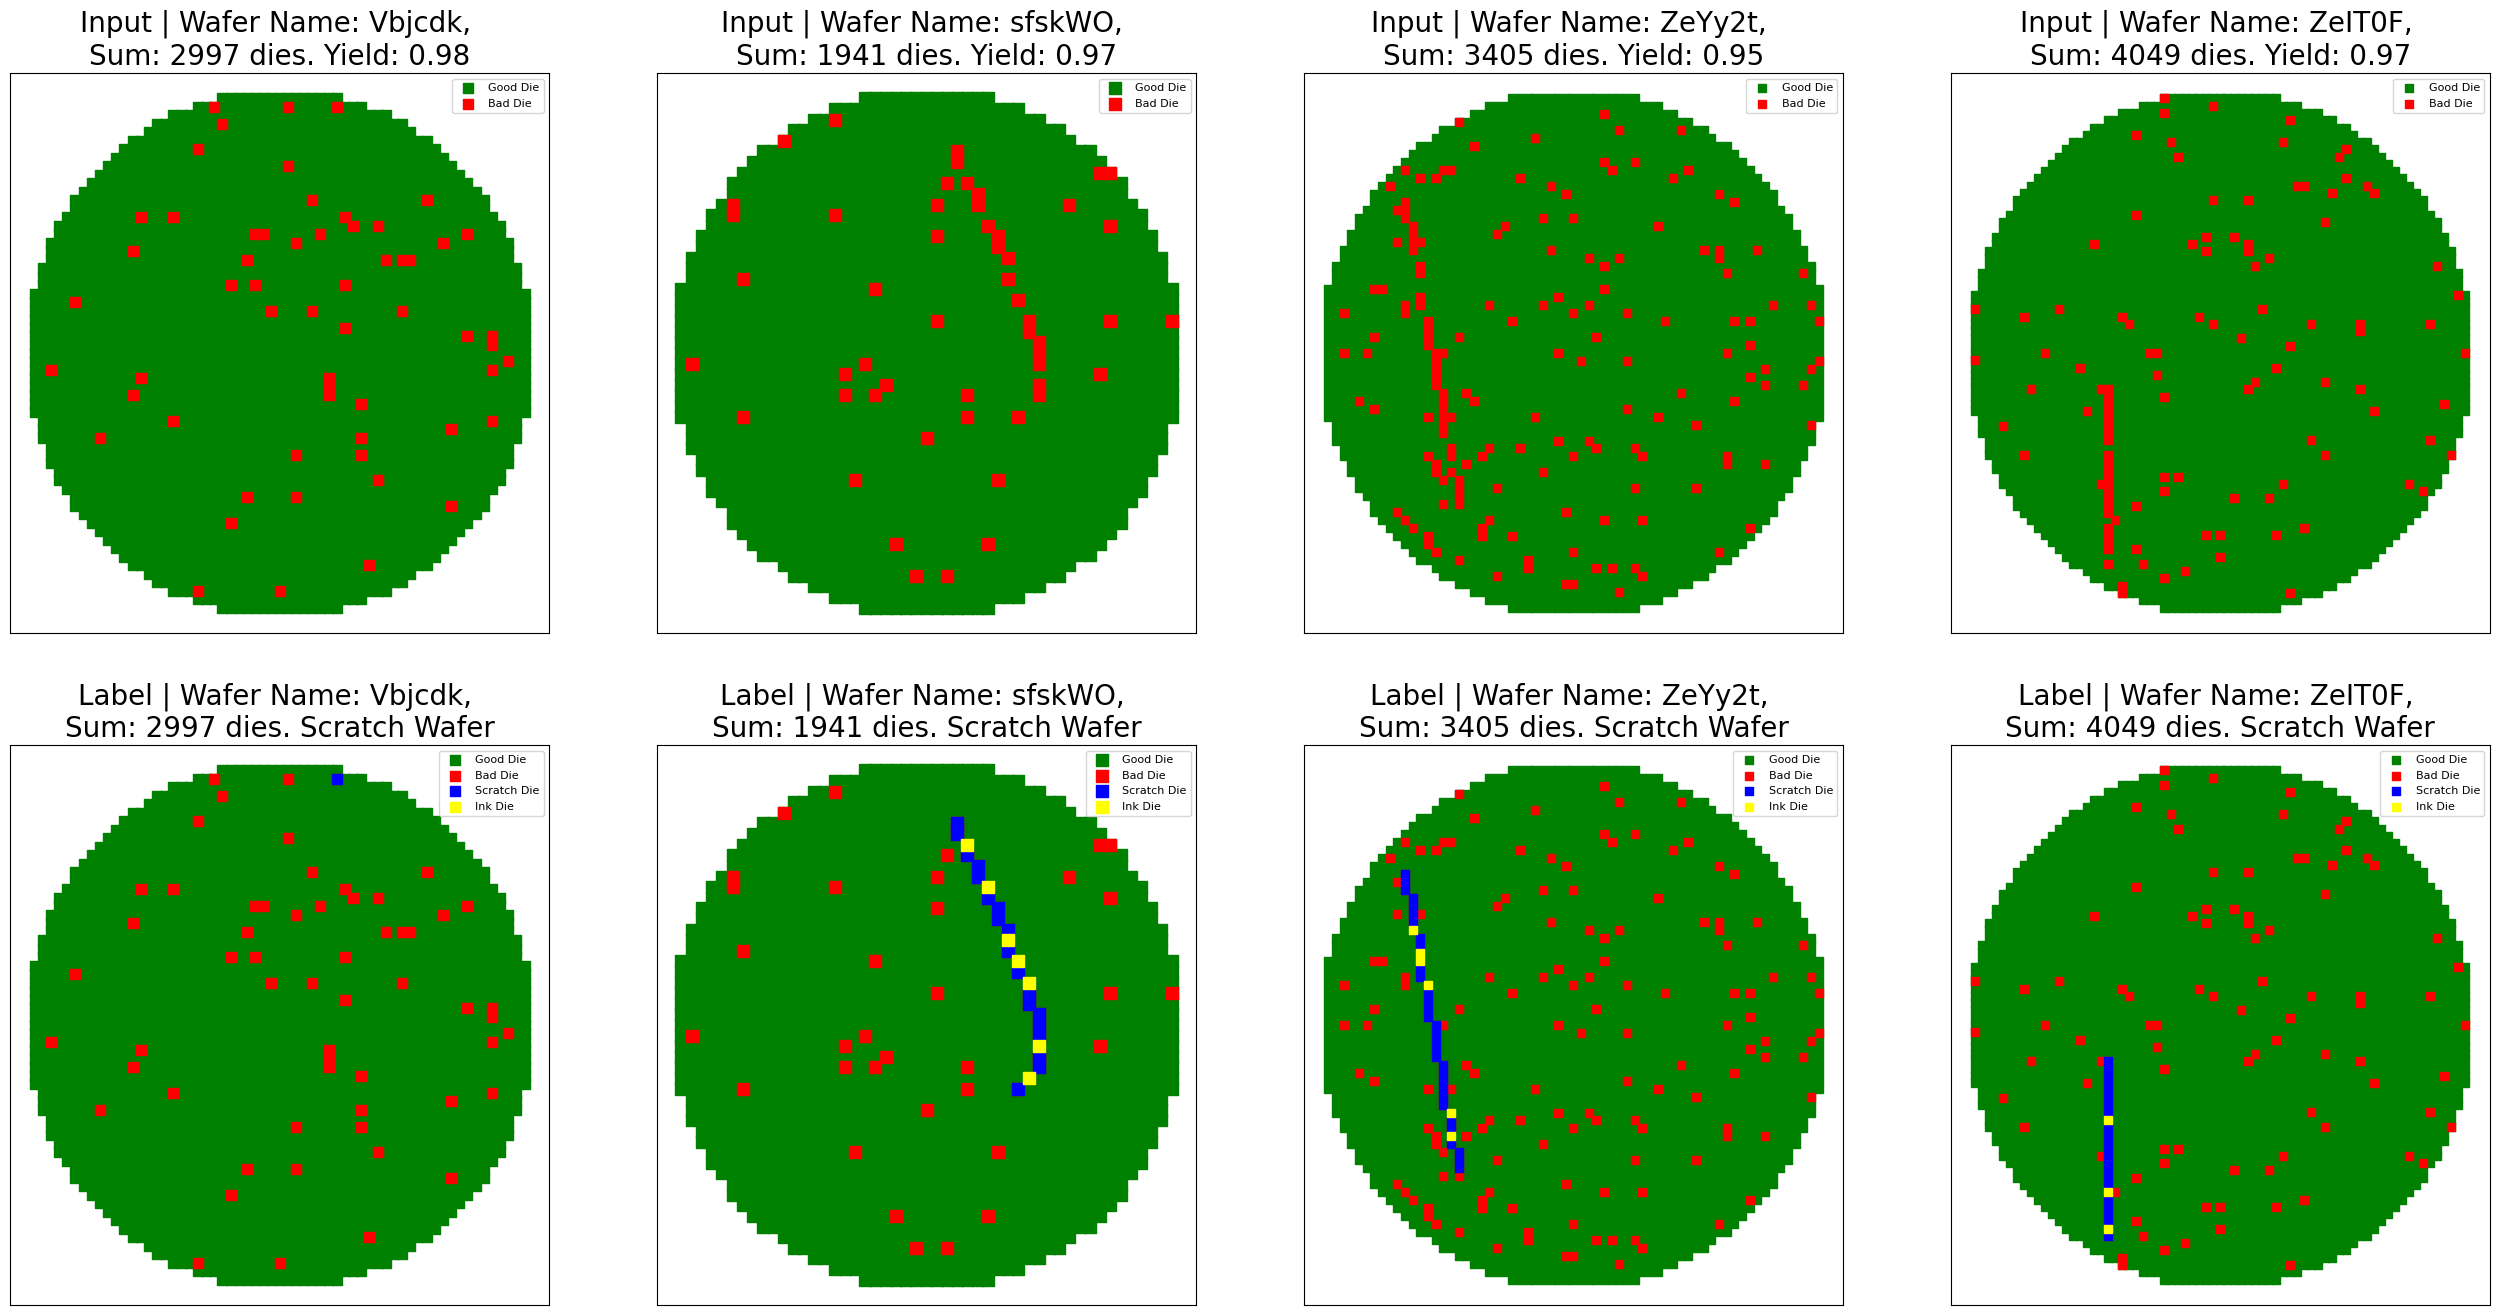

In [6]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

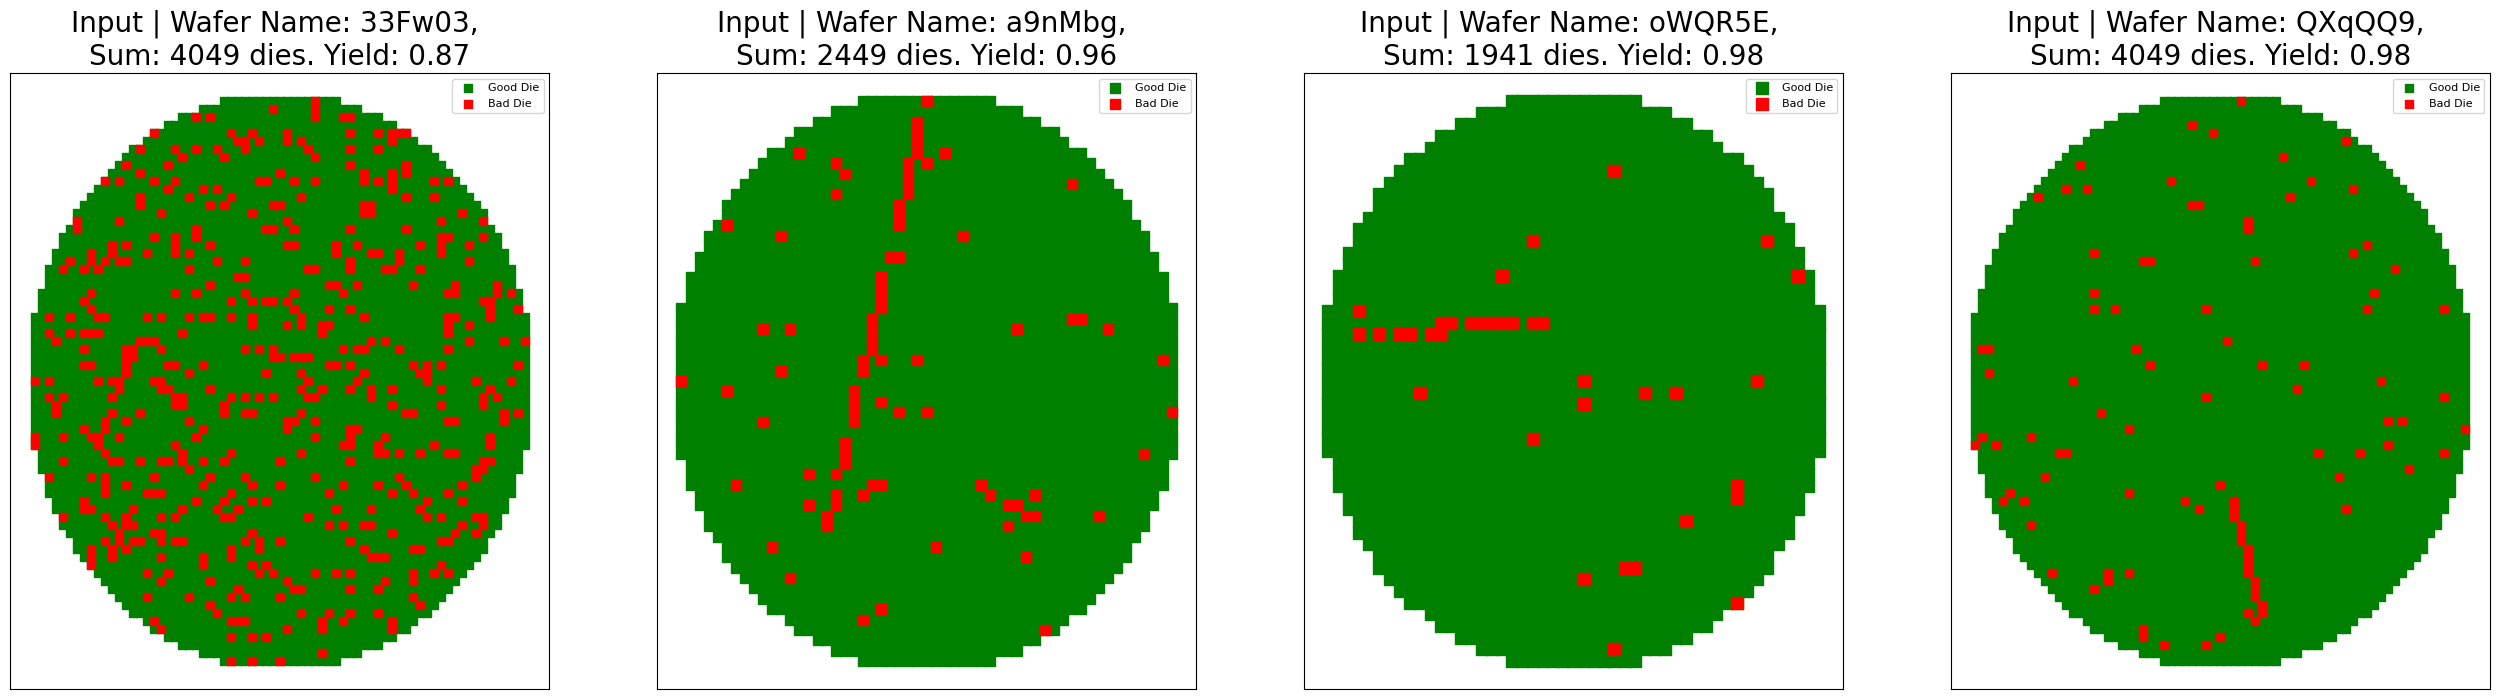

In [7]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

# Build your solution

#  Data Exploration

In [8]:
df_wafers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415400 entries, 0 to 10415399
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WaferName     object
 1   DieX          int64 
 2   DieY          int64 
 3   IsGoodDie     bool  
 4   IsScratchDie  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 258.3+ MB


In [9]:
for i in df_wafers:
 print(df_wafers[i].value_counts())

WaferName
GHlqOp    4049
JXy6ur    4049
8PFrAN    4049
28I7Oi    4049
Vy557e    4049
          ... 
gwjgvf    1005
fHmbu6    1005
ef1Ztr    1005
yrg3GH    1005
5ANCVA    1005
Name: count, Length: 4200, dtype: int64
DieX
25    225000
24    225000
27    223800
26    223800
28    222600
       ...  
66     22200
67     19800
68     17400
69     13800
70     10200
Name: count, Length: 71, dtype: int64
DieY
24    225000
25    225000
27    223800
26    223800
21    222600
       ...  
66     22200
67     19800
68     17400
69     13800
70     10200
Name: count, Length: 71, dtype: int64
IsGoodDie
True     10036478
False      378922
Name: count, dtype: int64
IsScratchDie
False    10335081
True        80319
Name: count, dtype: int64


We can see that the number of Scratch Die is way less then Number of non Scartched Dies so our priamry tool to evaluate our model won't Be accuarcy and will be recall (tp/tp+fp) accuracy is expected to be very high

In [10]:
wafers_with_scratches = df_wafers[df_wafers['IsScratchDie'] == True]['WaferName'].nunique()
print(f"Number of wafers with at least one scratch out of all wafers: {wafers_with_scratches}/{df_wafers['WaferName'].nunique()}")

Number of wafers with at least one scratch out of all wafers: 4073/4200


We can also see that most of the wafers have scratch on them

# Data analysis & Data Engineering


First i wanted to check if there is areas in the "wafer" that tend to be more "Scratchier"

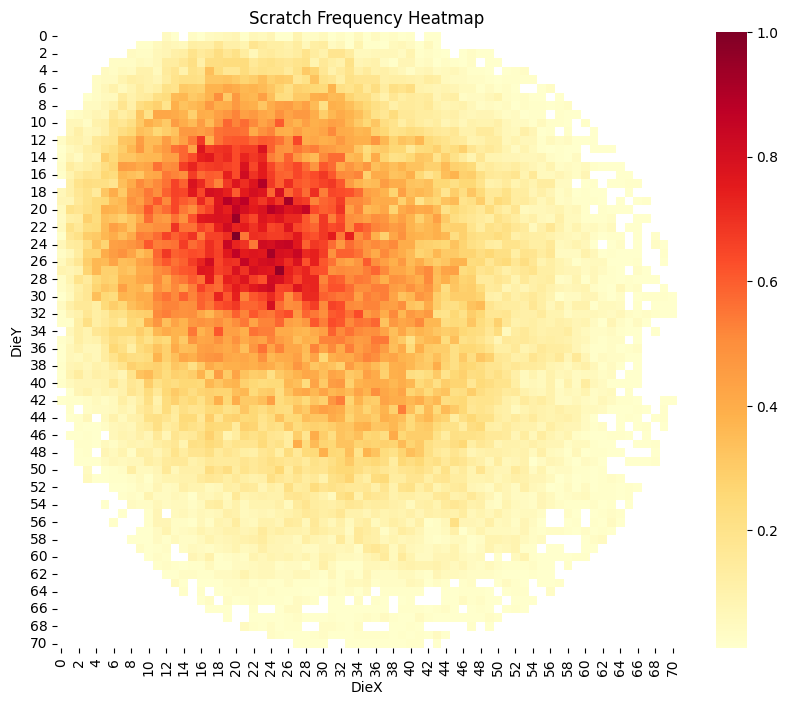

In [11]:
def create_heatmap(df):
  """
  create and show Scratch frequency heatmap (scelared)

  Args:
  df (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  heatmap_data (pandas.DataFrame): The DataFrame containing the heatmap data.

  """
  heatmap_data = df[df['IsScratchDie'] == True].groupby(['DieX', 'DieY'])['WaferName'].count().reset_index()
  heatmap_data.rename(columns={'WaferName': 'ScratchScore'}, inplace=True)
  heatmap_data['ScratchScore'] = heatmap_data['ScratchScore'] / heatmap_data['ScratchScore'].max() ##normalize
  heatmap_pivot = heatmap_data.pivot(index="DieY", columns="DieX", values="ScratchScore")
  plt.figure(figsize=(10, 8))
  sns.heatmap(heatmap_pivot, cmap="YlOrRd", annot=False)
  plt.title("Scratch Frequency Heatmap")
  plt.xlabel("DieX")
  plt.ylabel("DieY")
  plt.show()
  return heatmap_data
heatmap_data = create_heatmap(df_wafers)

We can see that based on the data we have there is areas that tend to be more "scratchier" So we will add a "ScratchCount" column to our df

/tmp/ipython-input-1465891114.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_wafers['ScratchScore'].fillna(0, inplace=True)


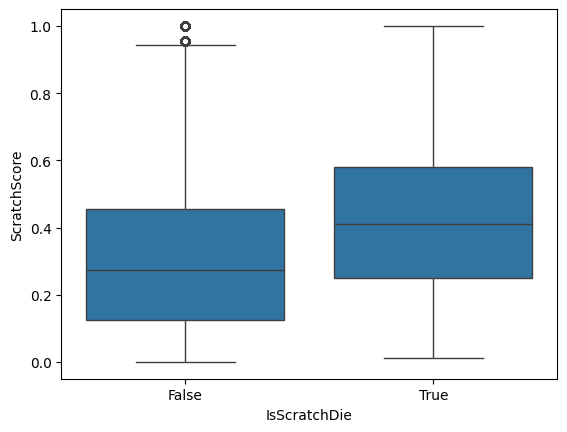

In [12]:
def add_scratch_count(df_wafers):
  """
  add Scratch
  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  df_wafers (pandas.DataFrame): The DataFrame containing the heatmap data.

  """
  df_wafers = pd.merge(df_wafers, heatmap_data, on=['DieX', 'DieY'], how='left')
  df_wafers['ScratchScore'].fillna(0, inplace=True)
  return df_wafers
df_wafers = add_scratch_count(df_wafers)

def create_boxplot(df_wafers):
  """
  create and show box plot of ScratchScore based on IsScratchDie

  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  None

  """
  sns.boxplot(x=df_wafers["IsScratchDie"], y=df_wafers['ScratchScore'])
  plt.show()
create_boxplot(df_wafers)

Now i want to check if there is correlation between number of Bad Dies to The number of Scratches dies

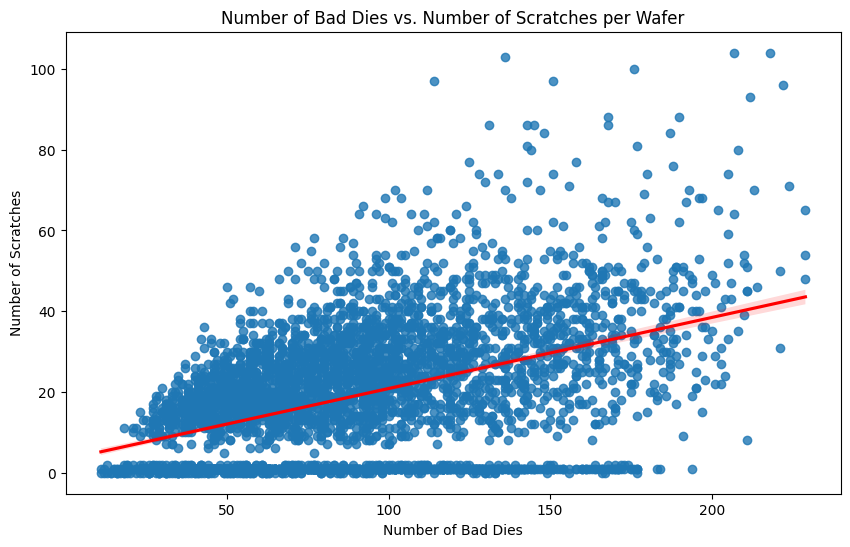

In [13]:
def create_regplot(df_wafers):
  """
  create and show regression plot of ScratchScore based on IsGoodDie

  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  None

  """
  wafer_stats = df_wafers.groupby('WaferName').agg(
      bad_dies=('IsGoodDie', lambda x: (x == False).sum()),
    scratches=('IsScratchDie', lambda x: (x == True).sum())
  ).reset_index()


# Create the scatter plot
  plt.figure(figsize=(10, 6))
  sns.regplot(x='bad_dies', y='scratches', data=wafer_stats, ci=95, line_kws={'color': 'red'})  # Added regression line and transparency
  plt.title('Number of Bad Dies vs. Number of Scratches per Wafer')
  plt.xlabel('Number of Bad Dies')
  plt.ylabel('Number of Scratches')
  plt.show()
create_regplot(df_wafers)

We can see that there is a correlation between Num of bad dies to the number of scratched dies so we will add a feature to each row giving a score (between 1 and 0) to the number of bad dies in the wafer (calculation will be NumOfBadDies/max(NumOfBadDies)

In [14]:
def create_bad_die_score(df_wafers):
  """
  add a column Bad_die_Score to df_wafers

  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  df_wafers (pandas.DataFrame): The DataFrame containing the data.

  """
  bad_counts = (~df_wafers['IsGoodDie']).groupby(df_wafers['WaferName']).sum()
  df_wafers['BadDieScore'] = df_wafers['WaferName'].map(bad_counts / bad_counts.max())
  return df_wafers
df_wafers = create_bad_die_score(df_wafers)



By looking at the wafer maps presented we can infer that bad dies are mostly continuous so we will create few features

HasBadNeighbor =>Is any Die adjacent to you is bad (Bool)

BadDieWithBadNeighbor => Is HasBadNeighbor True And IsGoodDie False (Bool)

NumBadNeighbors_3x3 = Number of BadNeighbors in your 3x3 area (int)

NumBadNeighbors_5x5	=Number of BadNeighbors in your 5x5 area (int)

HasBadNeighbor_5x5 = Similar to HasBadNeighbor just in the 5x5 Area (Bool)

NumBadNeighbors_7x7 = Number of BadNeighbors in your 7x7 area (int)

HasBadNeighbor_7x7 = Similar to HasBadNeighbor just in the 7x7 Area (Bool)

NumBadNeighbors_9x9 = Number of BadNeighbors in your 9x9 area (int)

HasBadNeighbor_9x9 = Similar to HasBadNeighbor just in the 9x9 Area (Bool)

In [15]:
def has_bad_neighbor(df, kernel_size=3):
    """
    Checks for bad neighbors using vectorized operations and calculates the number of bad neighbors
    within a specified kernel size.

    Args:
        df: The dataframe containing wafer data.
        kernel_size: The size of the kernel (e.g., 3 for 3x3, 5 for 5x5).

    Returns:
        A pandas DataFrame with 'HasBadNeighbor' and 'NumBadNeighbors' features.
    """
    df['HasBadNeighbor'] = False
    df[f'NumBadNeighbors_{kernel_size}x{kernel_size}'] = 0
    for wafer_name, group in tqdm(df.groupby('WaferName')):
      wafer_size = group[['DieX', 'DieY']].max() + 1 #because cords start from 0
      wafer_array = np.zeros(wafer_size, dtype=int)
      bad_dies = group[group['IsGoodDie'] == False][['DieX', 'DieY']].values
      wafer_array[bad_dies[:, 0], bad_dies[:, 1]] = 1
      kernel = np.ones((kernel_size, kernel_size), dtype=int) #creating karnel based on required size
      kernel[kernel_size // 2, kernel_size // 2] = 0
      neighbor_map = convolve2d(wafer_array, kernel, mode='same') #checks for neighboors using convolution
      df.loc[group.index, 'HasBadNeighbor'] = neighbor_map[group['DieX'].values, group['DieY'].values] > 0
      df.loc[group.index, f'NumBadNeighbors_{kernel_size}x{kernel_size}'] = neighbor_map[group['DieX'].values, group['DieY'].values]

    return df[['HasBadNeighbor', f'NumBadNeighbors_{kernel_size}x{kernel_size}']]
df_wafers[['HasBadNeighbor', 'NumBadNeighbors_3x3']] = has_bad_neighbor(df_wafers, kernel_size=3)
df_wafers[['HasBadNeighbor_5x5', 'NumBadNeighbors_5x5']] = has_bad_neighbor(df_wafers, kernel_size=5)
df_wafers[['HasBadNeighbor_7x7', 'NumBadNeighbors_7x7']] = has_bad_neighbor(df_wafers, kernel_size=7)
df_wafers[['HasBadNeighbor_9x9', 'NumBadNeighbors_9x9']] = has_bad_neighbor(df_wafers, kernel_size=9)
df_wafers['BadDieWithBadNeighbor'] = (df_wafers['IsGoodDie'] == False) & (df_wafers['HasBadNeighbor'] == True)

100%|██████████| 4200/4200 [00:11<00:00, 357.72it/s]


We Can also see that the most of the scratches of bad dies coming in sequences of bad dies so we will create a feature that insert that

In [17]:
import pandas as pd
import numpy as np
# from tqdm import tqdm # Assuming tqdm is available

def get_sequence_length_spatial(df, min_sequence_length=2):
    """
    Calculates the length of bad die sequences in the dataframe,
    considering good dies within a scratch by checking DieX and DieY coordinates.

    NOTE: This logic requires a conceptual 1D-sequence. The data is sorted by Y then X
    to create a consistent scan order before checking spatial proximity.

    Args:
        df: The dataframe containing wafer data with 'DieX', 'DieY', and 'IsGoodDie'.
        min_sequence_length: The minimum number of consecutive bad dies to consider as a sequence.

    Returns:
        A pandas Series with 'SequenceLength' representing the length of the sequence a die belongs to.
    """
    df['SequenceLength'] = 0  # Initialize the column

    for wafer_name, group in tqdm(df.groupby('WaferName')):


        group = group.sort_values(by=['DieY', 'DieX'])
        bad_dies_group = group[group['IsGoodDie'] == False].copy()
        bad_die_indices = bad_dies_group.index.values # Original index


        if len(bad_die_indices) < min_sequence_length:
            continue

        sequence_length = 0

        for i in range(len(bad_die_indices)):
            current_index = bad_die_indices[i]

            if i + 1 < len(bad_die_indices):
                next_index = bad_die_indices[i + 1]


                current_coords = group.loc[current_index, ['DieX', 'DieY']].values
                next_coords = group.loc[next_index, ['DieX', 'DieY']].values


                diff = np.abs(next_coords - current_coords)

                is_adjacent = np.sum(diff) == 1
                is_gap_of_one = np.sum(diff) == 2 and np.all(diff <= 2)

                if is_adjacent or is_gap_of_one:
                    sequence_length += 1
                else:

                    if sequence_length + 1 >= min_sequence_length:
                        for j in range(sequence_length + 1):

                            target_original_index = bad_die_indices[i - sequence_length + j]
                            df.loc[target_original_index, 'SequenceLength'] = sequence_length + 1

                    sequence_length = 0

            else:

                if sequence_length + 1 >= min_sequence_length:
                    for j in range(sequence_length + 1):
                        target_original_index = bad_die_indices[i - sequence_length + j]
                        df.loc[target_original_index, 'SequenceLength'] = sequence_length + 1

                sequence_length = 0
    return df['SequenceLength']

# Apply the function to create the feature
df_wafers['SequenceLength'] = get_sequence_length(df_wafers)

100%|██████████| 4200/4200 [04:08<00:00, 16.92it/s]


In [18]:
# prompt: for each row insert a score for how much bad die there is in the entire wafer (all_bad_in_wafer/max_bad_die_in_wafer)

# Calculate the total number of bad dies per wafer
bad_dies_per_wafer = df_wafers.groupby('WaferName')['IsGoodDie'].apply(lambda x: (x == False).sum())

# Calculate the maximum number of bad dies across all wafers
max_bad_dies = bad_dies_per_wafer.max()

# Create the 'BadDieRatio' column
df_wafers['BadDieRatio'] = df_wafers['WaferName'].map(bad_dies_per_wafer / max_bad_dies)


In [21]:
df_wafers

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie,ScratchScore,BadDieScore,HasBadNeighbor,NumBadNeighbors_3x3,NumBadNeighbors_5x5,HasBadNeighbor_5x5,NumBadNeighbors_7x7,HasBadNeighbor_7x7,NumBadNeighbors_9x9,HasBadNeighbor_9x9,BadDieWithBadNeighbor,SequenceLength,BadDieRatio
0,8PFrAN,0,27,True,False,0.090909,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
1,8PFrAN,0,28,True,False,0.034091,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
2,8PFrAN,0,29,True,False,0.034091,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
3,8PFrAN,0,30,True,False,0.011364,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
4,8PFrAN,0,31,True,False,0.045455,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10415395,CofPVD,64,36,True,False,0.011364,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480
10415396,CofPVD,64,37,True,False,0.034091,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480
10415397,CofPVD,64,38,True,False,0.011364,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480
10415398,CofPVD,64,39,True,False,0.000000,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480


# ML Implantation

As we Showed earlier we expect to get very high accuracy and our main goal is going to have high recall and high precision (hopefully balanced too) then high accuracy

In [22]:
def prepare_test_train(df_wafers):
  """
  prepare train and test data
  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  X_train (pandas.DataFrame): The DataFrame containing the data.
  """
  df = df_wafers[['IsGoodDie', 'HasBadNeighbor','SequenceLength','NumBadNeighbors_3x3','NumBadNeighbors_5x5',"HasBadNeighbor_7x7","NumBadNeighbors_7x7",'HasBadNeighbor_9x9','NumBadNeighbors_9x9','HasBadNeighbor_5x5','BadDieWithBadNeighbor', 'ScratchScore', 'BadDieScore', 'IsScratchDie']].copy()
  X = df.drop("IsScratchDie", axis=1)
  y = df["IsScratchDie"]
  X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)
  return X_train , X_test , y_train , y_test
X_train , X_test , y_train , y_test = prepare_test_train(df_wafers)

Firstly we will try using logistic regression (The most basic model for binary classification)

In [23]:
def lr(X_train, X_test, y_train, y_test):
  """
  Initialize and train a Logistic Regression model.
  Logistic Regression
  Args:
  X_train (pandas.DataFrame): The DataFrame containing the data.
  X_test (pandas.DataFrame): The DataFrame containing the data.
  y_train (pandas.DataFrame): The DataFrame containing the data.
  y_test (pandas.DataFrame): The DataFrame containing the data.

  Returns:
  lr_model (sklearn.linear_model.LogisticRegression): The trained
  """
  lr_model = LogisticRegression()
  lr_model.fit(X_train, y_train)
  y_pred = lr_model.predict(X_test)
  print(classification_report(y_test, y_pred))
  return lr_model
lr_model = lr(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00   2067053
        True       0.83      0.61      0.71     16027

    accuracy                           1.00   2083080
   macro avg       0.91      0.81      0.85   2083080
weighted avg       1.00      1.00      1.00   2083080



We got recall score of 0.61 and precision of 0.83 on this model

Our 2nd model will be GBDT (Gradient Boosted Decision Trees) using LightGBM
Library Mostly because it Scalability and Speed (appropriate with the 10 Millions rows we have as dataset)

In [24]:
def lgbm(X_train, X_test, y_train, y_test):
  """
  Initialize and train a GBDT model.
  Args:
  X_train (pandas.DataFrame): The DataFrame containing the data.
  X_test (pandas.DataFrame): The DataFrame containing the data.
  y_train (pandas.DataFrame): The DataFrame containing the data.
  y_test (pandas.DataFrame): The DataFrame containing the data.

  Returns:
  model (lgb model): The trained model
  """
  train_data = lgb.Dataset(X_train, label=y_train)
  test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
  params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
  }

  num_round = 100
  lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

  y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
  y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
  print(classification_report(y_test, y_pred_binary))
  return lgb_model
lgb_model = lgbm(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Number of positive: 64292, number of negative: 8268028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.478849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 8332320, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007716 -> initscore=-4.856716
[LightGBM] [Info] Start training from score -4.856716
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   2067053
        True       0.85      0.72      0.78     16027

    accuracy                           1.00   2083080
   macro avg       0.92      0.86      0.89   2083080
weighted avg       1.00      1.00      1.00   2083080



We got recall score of 0.72 and precision of 0.85 on this model

The 3rd model we will check will be a NN model with 2 hidden layers with Relu as activation  function and output layer with sigmoid as activation fuinction for binary classification

In [25]:
def nn_model(df_wafers):
  """
  Initialize and train a NN model.
  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.
  Returns:
  nn_model (tf.keras.Model): The trained nn_model
  """
  if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
    print("GPU is being used.")
  else:
    print("GPU is not available. Using CPU instead.")
  df = df_wafers[['IsGoodDie', 'HasBadNeighbor','SequenceLength','NumBadNeighbors_3x3','NumBadNeighbors_5x5',"HasBadNeighbor_7x7","NumBadNeighbors_7x7",'HasBadNeighbor_5x5','BadDieWithBadNeighbor', 'ScratchScore', 'BadDieScore', 'IsScratchDie']].copy()
  for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)
  X = df.drop("IsScratchDie", axis=1)
  y = df["IsScratchDie"]
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) #creating 60% train 20%val 20% test



  nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)), #first hidden layer
    tf.keras.layers.Dense(8, activation='relu'), #second hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])
  early_stopping = EarlyStopping(
    monitor='val_recall',
    patience=5,
    mode='max',
    restore_best_weights=True
) #initializing early stop method if recall doesnt imrpove for 5 epochs restoring the best weights



  nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall(), Precision(), BinaryAccuracy()])
  nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2,
    batch_size=32,
    callbacks=[early_stopping] #won't be neccessery because we gonna train on 2 epochs
)
  y_pred = nn_model.predict(X_test)
  y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
  print(classification_report(y_test, y_pred_binary))
  return nn_model
nn_model = nn_model(df_wafers)


GPU is not available. Using CPU instead.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
195289/195289 ━━━━━━━━━━━━━━━━━━━━ 374s 2ms/step - binary_accuracy: 0.9964 - loss: 0.0137 - precision: 0.8155 - recall: 0.6906 - val_binary_accuracy: 0.9967 - val_loss: 0.0109 - val_precision: 0.8030 - val_recall: 0.7502
Epoch 2/2
195289/195289 ━━━━━━━━━━━━━━━━━━━━ 357s 2ms/step - binary_accuracy: 0.9967 - loss: 0.0110 - precision: 0.8266 - recall: 0.7191 - val_binary_accuracy: 0.9967 - val_loss: 0.0110 - val_precision: 0.8209 - val_recall: 0.7325
65097/65097 ━━━━━━━━━━━━━━━━━━━━ 47s 726us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2067053
           1       0.81      0.74      0.78     16027

    accuracy                           1.00   2083080
   macro avg       0.90      0.87      0.89   2083080
weighted avg       1.00      1.00      1.00   2083080



We can see that the LightGBM model and the NN model had very similar result but the LightGBM model had slightly better results so we will choose it (The NN model had more recall but less precision and the LightGBM had slightly less recall but more precision)

In [26]:
model = lgb_model #prepare model and test df
df_wafers_test_copy = df_wafers_test.copy()
df_wafers_test_copy = add_scratch_count(df_wafers_test_copy)
df_wafers_test_copy = create_bad_die_score(df_wafers_test_copy)
df_wafers_test_copy[['HasBadNeighbor', 'NumBadNeighbors_3x3']] = has_bad_neighbor(df_wafers_test_copy, kernel_size=3)
df_wafers_test_copy[['HasBadNeighbor_5x5', 'NumBadNeighbors_5x5']] = has_bad_neighbor(df_wafers_test_copy, kernel_size=5)
df_wafers_test_copy[['HasBadNeighbor_7x7', 'NumBadNeighbors_7x7']] = has_bad_neighbor(df_wafers_test_copy, kernel_size=7)
df_wafers_test_copy[['HasBadNeighbor_9x9', 'NumBadNeighbors_9x9']] = has_bad_neighbor(df_wafers_test_copy, kernel_size=9)
df_wafers_test_copy['BadDieWithBadNeighbor'] = (df_wafers_test_copy['IsGoodDie'] == False) & (df_wafers_test_copy['HasBadNeighbor'] == True)
df_wafers_test_copy['SequenceLength'] = get_sequence_length(df_wafers_test_copy)

/tmp/ipython-input-1465891114.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_wafers['ScratchScore'].fillna(0, inplace=True)
100%|██████████| 455/455 [01:03<00:00,  7.18it/s]


In [27]:
df_wafers_test_copy.drop('WaferName', axis=1, inplace=True)
df_wafers_test_copy.drop('DieX', axis=1, inplace=True)
df_wafers_test_copy.drop('DieY', axis=1, inplace=True)

In [28]:
training_columns = X_train.columns.tolist()
df_wafers_test_copy = df_wafers_test_copy[training_columns]
df_wafers_test_copy

,IsGoodDie,HasBadNeighbor,SequenceLength,NumBadNeighbors_3x3,NumBadNeighbors_5x5,HasBadNeighbor_7x7,NumBadNeighbors_7x7,HasBadNeighbor_9x9,NumBadNeighbors_9x9,HasBadNeighbor_5x5,BadDieWithBadNeighbor,ScratchScore,BadDieScore
0,True,False,0,0,0,False,0,False,0,False,False,0.022727,0.014810
1,True,False,0,0,0,False,0,False,0,False,False,0.068182,0.014810
2,True,False,0,0,0,False,0,False,0,False,False,0.034091,0.014810
3,True,False,0,0,0,False,0,False,0,False,False,0.056818,0.014810
4,True,False,0,0,0,False,0,False,0,False,False,0.090909,0.014810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128330,True,False,0,0,0,False,0,False,0,False,False,0.363636,0.043724
1128331,True,False,0,0,0,False,0,False,0,False,False,0.284091,0.043724
1128332,True,False,0,0,0,False,0,False,0,False,False,0.295455,0.043724
1128333,True,False,0,0,0,False,0,False,0,False,False,0.329545,0.043724
